In [168]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd 

In [169]:
data_dir = '../dataset'
#print(os.listdir(data_dir))
filename = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [170]:
file = open(filename)
data = file.read()
file.close()

In [171]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1: ]

print(len(header))
print(len(lines))

15
420551


In [172]:
shape = len(lines), len(header) - 1

float_data = np.zeros(shape=shape)

print(float_data.shape)

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

(420551, 14)


## Works with whole data

[-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]
420551


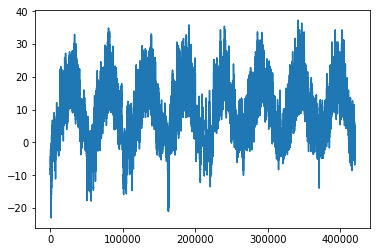

In [49]:
temp = float_data[:, 1]
print(temp)
print(len(temp))
plt.plot(temp)
plt.show()

## Works with only 10 days

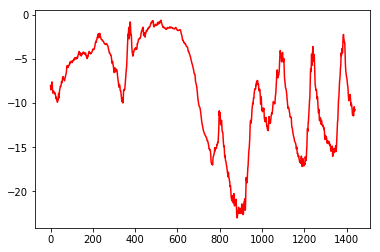

In [50]:
temp = float_data[:1440, 1]

plt.plot(temp, c='r')
plt.show()

## Works with only 1 days

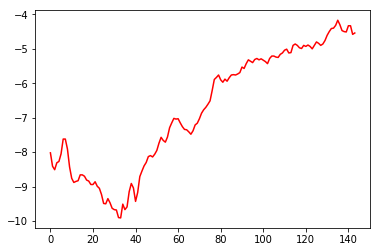

In [51]:
temp = float_data[:144, 1]
x = range(len(temp))
y = temp

plt.plot(x, y, c='r')
plt.show()



<h1> Is this timeseries predictable at a daily scale? </h1>

<p> jena_climate_2009_2016.csv এ ১০ মিনিট পর পর record রয়েছে। তাহলে একদিনের 24*60 = 1440/10 = 144 মিনিটের ডাটা রয়েছে। We want to predict daily timeseriece prediction. </p> 

<ol>
    <li> <b> loopback : </b>   144*5 = 720 mins ৫(৭২০) দিন পূর্বের ডাটার সময় </li>
  <li> <b> delay          : </b> = 144 * 1 = 144mins  = একদিন পর পর predict করবে </li>
    <li> <b> steps        : </b>   = 144/24 = 6 এটির মানে প্রত্যেক ঘন্টা পর পর ডাটা predict করবে। </li>
</ol>

<h1>  Preparing the data </h1>
অামাদের data prepare করার জন্য দুটি step follow করতে হবে।


<ol>
    <li> <b> Apply statistics tools : </b>   যেহেতু ডাটা random wise. দেখা যাচ্ছে এক দিনের temperature -20c, অাবার অন্য দিনের temperature +30 c. তাই এই ডাটাকে চিনতে হলে এদের মধ্যে similarity বের করার জন্য <b> standard deviation </b> apply করব। এখন standard deviation এর সময় square difference করা হয় কেন? কারণ negative vlaue ও থাকে তাই square করে rooot করে ফলে negative value টাও অামরা পাই। </li>
  <li> <b> Write python generator     : </b> এক সাথে 200000 trainable data memory তে লোড করে রেখে কাজ করা explicitly expensive তাই generator use করব। </li>
</ol>

<h1> Normalizing the data using mean & SD </h1>

<ol>
    <li> <b> mean : </b>   যতগুলো এলিমেন্ট নিয়ে কাজ করা হচ্ছে সেগুলোর যোগফলকে মোট এলিমেন্ট সংখ্যা দিয়ে ভাগ করলেই গড় পাওয়া যায়। </li>
  <li> <b> median     : </b> ক্রমানুসারে সাজানো এলিমেণ্টের মাঝখানের ভ্যালুটি। <span style="color: #ddd"># 4, 7, 9, 10, 12, 14, 15. এখানে 10 median. Mean & median approxiamately same. </span>  </li>
   <li> <b> mode     : </b> ক্রমানুসারে সাজানো এলিমেণ্টের মাঝখানের ভ্যালুটি। <span style="color: #ddd"> # 10, 14, 4, 7, 9, 12, 4, 15 এখানে 4 এর উপস্থিতি বেশি </span>  </li>
    <li> <b> ভ্যারিয়েন্স ও স্ট্যান্ডার্ড ডেভিয়েশন    : </b> ডাটা গুলো গড় মান থেকে কতটা ছড়ানো বা এর থেকে কত দুরে অবস্থিত সেক্ষেত্রে যে ফ্যাক্টরটি সম্বদ্ধে জানতে হবে সেটি হচ্ছে উক্ত ডিস্ট্রিবিউশনের ভ্যারিয়েন্স। </span>  </li>
</ol>


In [52]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean 
std = float_data[:200000].std(axis=0)
float_data /= std # normalization distibution, মুল ডাটার গড় থেকে কত দুরে


<h1> Generator yielding timeseries samples and their targets </h1>

<ol>
    <li> <b>generator function: </b> for training, one for validation, and one for testing</li>
</ol>



In [53]:
def generator(data, lookback, delay, min_index, max_index,
shuffle=True, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                rows = np.arange(i, min(i + batch_size, max_index))
                i += len(rows)
        samples = np.zeros((len(rows),
        lookback // step,
        data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

# Preparing the training, validation, and test generators

<ol>
    <li> <b> train_gen : </b> Learn the functions </li>
  <li> <b> val_gen     : </b> কত খানি শিখছে তা validate করা </li>
    <li> <b>test_gen    : </b> সাথে সাথে test করে দেখা যে সে কতখানি শিখছে  </li>
    <li> <b>val_steps    : </b> How many steps to draw from val_gen in order to see the entire validation set  </li>
    <li> <b>test_steps    : </b> How many steps to draw from test_gen in order to see the entire test setে  </li>
</ol>


In [54]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, 
                          step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, 
                    step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None,
                            step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

# non-machine-learning baseline

In [55]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2896087804165279


# Training and evaluating a densely connected model

In [37]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                                validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 651s 1s/step - loss: 1.4521 - val_loss: 0.4844
Epoch 2/20
500/500 [==============================] - 649s 1s/step - loss: 0.4709 - val_loss: 0.4211
Epoch 3/20
500/500 [==============================] - 652s 1s/step - loss: 0.3069 - val_loss: 0.3594
Epoch 4/20
500/500 [==============================] - 652s 1s/step - loss: 0.2720 - val_loss: 0.3166
Epoch 5/20
500/500 [==============================] - 653s 1s/step - loss: 0.2551 - val_loss: 0.3415
Epoch 6/20
500/500 [==============================] - 649s 1s/step - loss: 0.2472 - val_loss: 0.3642
Epoch 7/20
500/500 [==============================] - 652s 1s/step - loss: 0.2385 - val_loss: 0.3169
Epoch 8/20
500/500 [==============================] - 651s 1s/step - loss: 0.2357 - val_loss: 0.3269
Epoch 9/20
500/500 [==============================] - 649s 1s/step - loss: 0.2274 - val_loss: 0.3183
Epoch 10/20
500/500 [==============================] - 648s 1s/step - loss: 0.2235 - val_lo

In [ ]:
# Plotting results

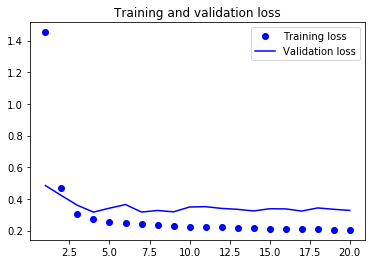

In [40]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
# Using add GRU layer

In [79]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=50, epochs=10, validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.3593

KeyboardInterrupt: 

In [63]:
model_name = 'weather_timeseries_model.h5'
model.save(model_name)
print('Save to ', os.getcwd())
! ls -lstr

Save to  /home/semanticslab3/salam/NLP
total 5464
   4 drwxrwxr-x 2 semanticslab3 semanticslab3    4096 Oct 10 12:08 glove.6B
   4 -rw-rw-r-- 1 semanticslab3 semanticslab3      14 Oct 10 12:08 hello.txt
   4 drwxr-xr-x 4 semanticslab3 semanticslab3    4096 Oct 10 12:10 imdb
   4 -rw-rw-r-- 1 semanticslab3 semanticslab3    3118 Oct 10 12:55 Character-level-one-hot-encoding.ipynb
   8 -rw-rw-r-- 1 semanticslab3 semanticslab3    5054 Oct 10 13:28 IMDB data.ipynb
   8 -rw-rw-r-- 1 semanticslab3 semanticslab3    5759 Oct 10 13:29 HARDCODE--Character-levle-one-hot-endcoding.ipynb
   8 -rw-rw-r-- 1 semanticslab3 semanticslab3    5725 Oct 10 14:23 Using-keras-word-embedding.ipynb
   4 -rw-rw-r-- 1 semanticslab3 semanticslab3    3074 Oct 10 14:42 Using-keras-for-word-level-one-hot-encoding.ipynb
   8 -rw-rw-r-- 1 semanticslab3 semanticslab3    4875 Oct 10 14:48 HARDCODE--word-levle-one-hot-endcoding.ipynb
5176 -rw-rw-r-- 1 semanticslab3 semanticslab3 5296496 Oct 10 18:06 pre_trained_glove_model

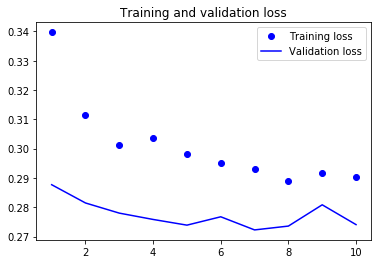

In [62]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Save model

In [92]:
from keras.models import load_model

model_name = 'weather_timeseries_model.h5'
loaded_model = load_model(model_name)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


#  Testing model

In [96]:
test = float_data[:1]
print(test.shape)

test = test.reshape(1, 1, 14)
predict = loaded_model.predict(test)


print('pred           :', predict)
print('pred lenght    :', len(predict[0]))
best_prediction = predict.argmax()
print('best_prediction:', best_prediction)

(1, 14)
pred           : [[-1.2705332]]
pred lenght    : 1
best_prediction: 0


# Recurrent dropout to fight overfitting